In [1]:
import os
import shutil
from pathlib import Path
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
from PIL import Image
from torchvision import models, transforms, datasets
import torch.nn.functional as F



2025-09-22 20:17:43.276346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})

SEED = 900729
dir_path = './data'
train_path = './data/Training'
test_path = './data/Testing'
validation_path = './data/Validation'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devic: {device}")

if os.path.exists(dir_path):
    print("Dane juz istnieją")
else:
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('masoudnickparvar/brain-tumor-mri-dataset', path='./data', unzip=True)
    tr_orginal_df = load(train_path)
    ts_df = load(test_path)
    val_df, tr_df = train_test_split(tr_orginal_df, train_size=0.25, random_state=SEED, stratify=tr_orginal_df['Class'])
    validation_path = './data/Validation'
    Path(validation_path).mkdir(exist_ok=True)

    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for class_name in classes:
        class_validation_path = Path(validation_path) / class_name
        class_validation_path.mkdir(exist_ok=True)

    errors = []

    for idx, row in val_df.iterrows():
        try:
            source_path = Path(row['Class Path'])

            filename = source_path.name
            class_name = row['Class']
            destination_path = Path(validation_path) / class_name / filename

            shutil.move(str(source_path), str(destination_path))

        except Exception as e:
            errors.append({
                'file': row['Class Path'],
                'class': row['Class'],
                'error': str(e)
            })


    if errors:
        print(f"Errors: {len(errors)}")
        for error in errors:
            print(f"  - {error['class']}: {Path(error['file']).name} - {error['error']}")

    val_df_updated = val_df.copy()
    val_df_updated['Class Path'] = val_df_updated.apply(
        lambda row: str(Path(validation_path) / row['Class'] / Path(row['Class Path']).name),
        axis=1
    )

    tr_df_updated = load(train_path)

    val_df = val_df_updated
    tr_df = tr_df_updated
    print("Pomyślnie pobrano dane")



data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=test_path, transform=data_transforms)
val_dataset   = datasets.ImageFolder(root=validation_path, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


Devic: cuda
Dane juz istnieją


In [ ]:
device = torch.device('cpu')

model = models.swin_t(weights='DEFAULT')
model.head = torch.nn.Linear(model.head.in_features, len(train_dataset.classes))
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 10
best_val_loss = float('inf')

if os.path.exists('best_model_Swin.pth'):
    model.load_state_dict(torch.load('best_model_Swin.pth'))
    print("Wczytano zapisany model Swin Transformer")
else:
    print("Rozpoczynanie treningu Swin Transformer...")
    
    for epoch in range(EPOCHS):
        # Faza treningowa
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_Swin.pth')
            print(f"Zapisano nowy najlepszy model z stratą walidacyjną: {val_loss:.4f}")

    # Wykresy strat i dokładności
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('swin_training_history.png')
    plt.show()

model.load_state_dict(torch.load('best_model_Swin.pth'))
print(f"Trening zakończony. Najlepsza strata walidacyjna: {best_val_loss:.4f}")

Wczytano zapisany model Swin Transformer
Trening zakończony. Najlepsza strata walidacyjna: inf


Test Loss: 0.0426
Test Accuracy: 98.32%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.96      0.98      0.97       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


Confusion Matrix:


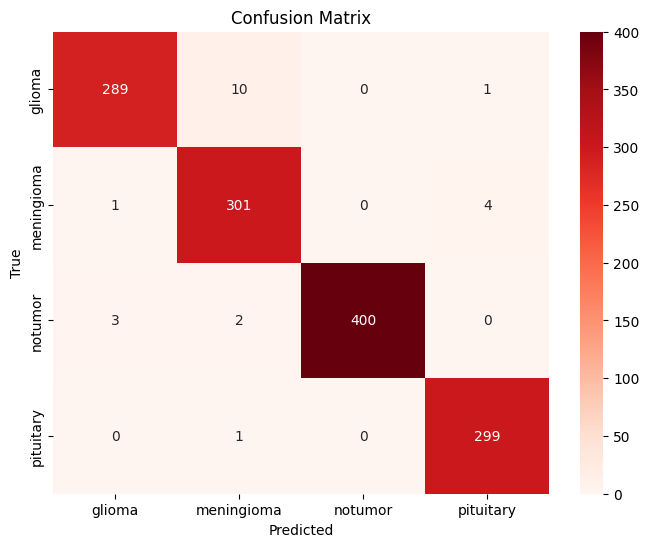

In [4]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()